In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gym
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
#DQN
#Off-policy, Model-free, Bootstrap method

In [2]:
#(1) Q-network
def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    model = keras.Sequential([
        keras.layers.Dense(fc1_dims, activation='relu'), #1st layer DNN
        keras.layers.Dense(fc2_dims, activation='relu'), #2nd layer DNN
        keras.layers.Dense(n_actions, activation=None)]) #Q(s,a_1), Q(s,a_1), ....Q(s,a_{n_actions}) : Size of output is number of actions
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
    return model

In [3]:
#(2) Replay Buffer
class ReplayBuffer():
    def __init__(self, max_size, input_dims): #initializer 
        self.mem_size = max_size
        self.mem_cntr = 0 #memory counter: keep track of the position of first un-saved memory
                          #When memory is full: agent goes to the begining and start rewriting. 
        # Memory is set of numpy array
        # [state_memory, action_memory, reward_memory, new_state_memory]
        self.state_memory = np.zeros((self.mem_size, *input_dims), 
                                    dtype=np.float32) # start memory
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32) #action (int: discrete action)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32) #reward
        self.new_state_memory = np.zeros((self.mem_size, *input_dims),
                                dtype=np.float32) #state trandition
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.int32) #keep track of our "done" flag

    #To add the transition(state action reward state_ done) to the memory buffer
    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size #index of first unoccupied memory
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = 1 - int(done)
        self.mem_cntr += 1
       
    #To sample from memory buffer      
    def sample_buffer(self, batch_size):
        # We sample buffer from 0 upto max_mem. 
        # If buffer is totally full, we sample until mem_size, otherwise until mem_counter)
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False) # sample upto max_mem with the size of batch_size
        # replace = False: if we select sample once, then we are selecting them again.
        # batch is array of indexs
        
        # Let's do sampling
        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        rewards = self.reward_memory[batch]
        actions = self.action_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

In [4]:
#(3) Agent
class Agent():
    #initializer
    def __init__(self, lr, gamma, n_actions, epsilon, batch_size,
                input_dims, epsilon_dec=1e-3, epsilon_end=0.01, # decrease epsildon til epsilon_end wt the rate of epsilson_dec (rate of exploration)
                mem_size=1000000, fname='dqn_model.h5'): 
        self.action_space = [i for i in range(n_actions)] 
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = epsilon_dec
        self.eps_min = epsilon_end
        self.batch_size = batch_size
        self.model_file = fname
        self.memory = ReplayBuffer(mem_size, input_dims)
        self.q_eval = build_dqn(lr, n_actions, input_dims, 256, 256)
     
    #interface function between Agent and memory (ReplayBuffer)
    def store_transition(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, observation):
        # Exploration
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        # Exploitation
        else:
            state = np.array([observation])
            #action predicted by maximum Q values (predicted by q_eval(agent))
            actions = self.q_eval.predict(state)
            action = np.argmax(actions)

        return action

    # learning by minimizing loss between q_target and q_eval(agent)'s prediction
    def learn(self):
        # We don't want to do learning unless memory has been filled more than batch_size
        if self.memory.mem_cntr < self.batch_size:
            return

        states, actions, rewards, states_, dones = \
                self.memory.sample_buffer(self.batch_size)

        q_eval = self.q_eval.predict(states) #Q(s,a)
        q_next = self.q_eval.predict(states_) #Q(s',a') <-s' is new state (s,a,r,s')

        #target q-value: The target is the direction which we want update the move of weight 
        # copy q_eval to q_target first
        q_target = np.copy(q_eval) # assignment 
        batch_index = np.arange(self.batch_size, dtype=np.int32) # array indexing
                 
        # Updating q_target value for the actions that agent actually took with r + gamma*max(Q(s',a')) (Bellman function)
        # so, for each state of our batch, for action actually took, we want to update that by r + gamma*max(Q(s',a'))
        # "*done": terminal state = done is 0
        q_target[batch_index, actions] = rewards + \
                        self.gamma * np.max(q_next, axis=1)*dones
        # Training!
        # learning by minimizing loss between q_target and q_eval(agent)'s prediction
        # loss = {q_target: r + gamma*max(Q(s',a')}-{prediction: Q(s,a)} 
        # This will recompute and predict states and take the delta 
        # between the output of that feedforward that predict (Q(s,a)) and q_target (Q(s',a'))
        self.q_eval.train_on_batch(states, q_target)
        # Linear decay of the rate of exploration 
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > \
                self.eps_min else self.eps_min

    def save_model(self):
        self.q_eval.save(self.model_file)


    def load_model(self):
        self.q_eval = load_model(self.model_file)
    
    def test_model(self, observation):
        self.q_eval = load_model(self.model_file)
        state = np.array([observation])
        actions = self.q_eval.predict(state)
        action = np.argmax(actions)
        return action

In [5]:
#train
tf.compat.v1.disable_eager_execution()
env = gym.make('LunarLander-v2')
lr = 0.001
n_games = 3000
agent = Agent(gamma=0.99, epsilon=1.0, lr=lr, 
            input_dims=env.observation_space.shape,
            n_actions=env.action_space.n, mem_size=1000000, batch_size=64,
            epsilon_end=0.01, fname='dqn_model.h5')
scores = []
eps_history = []

for i in range(n_games):
    done = False
    score = 0 # compute summed reward
    observation = env.reset()
    if i%1000==0:
        print("train step: "+str(i))
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.store_transition(observation, action, reward, observation_, done)
        observation = observation_
        agent.learn()
    eps_history.append(agent.epsilon)
    scores.append(score)
agent.save_model()
avg_score = np.mean(scores[-100:])
print('episode: ', i, 'score %.2f' % score,'average_score %.2f' % avg_score,'epsilon %.2f' % agent.epsilon)

train step: 0


/Users/sookim/miniconda3/envs/aiai2022-rl/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2022-01-01 16:56:53.309382: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


train step: 1000
train step: 2000
episode:  2999 score -99.60 average_score -446.22 epsilon 0.01


In [6]:
def plotLearning(x, scores, epsilons, filename, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    #ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1")
    ax2.set_ylabel('Score', color="C1")
    #ax2.xaxis.set_label_position('top')
    ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)

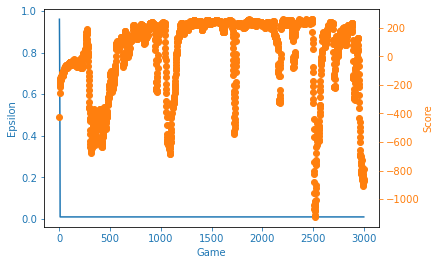

In [7]:
filename = 'lunarlander_tf2.png'
x = [i+1 for i in range(n_games)]
plotLearning(x, scores, eps_history, filename)

In [8]:
for i in range(100):
    observation = env.reset()
    for t in range(100):
        env.render() #play video of episode playing 
        action = agent.test_model(observation)
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()   

IndexError: list index out of range